# Corny: Density estimation

### TODO
- Modify code below to predict on test set with MSE Loss model, and Custom density loss model
- The outcomes should be dict with keys as the image name and values as the predicted counts (see `test_dict` generated by `count_instances()` below)
- Count MAPE using provided `count_mape()` function
- Plot the predicted counts against the true counts

In [16]:
import sys
import torch
sys.path.append("../corny/density estimation/")
# from unet_smp import UNetLightningModule
from unet_vanilla import UNetLightningModule
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms

model_type = "unet_vanilla"
log_version = "version_18"
checkpoint_filename = "epoch=39-step=1880.ckpt"   # epoch=99-step=2400.ckpt 

checkpoint_path = f"../logs/tb_logs/{model_type}/{log_version}/checkpoints/{checkpoint_filename}"
checkpoint = torch.load(checkpoint_path)
hparams = {
    # Model hyperparameters
    "in_channels": 3,
    "out_channels": 1,
    "decoder_channels": (512, 256, 128, 64, 32),
    'features': [64, 128, 256, 512],
    "learning_rate": 1e-4,
    # Data hyperparameters
    "batch_size": 16,
    "num_workers": 1,
    # Training hyperparameters
    "max_epochs": 10,
    # Paths
    "train_image_dir": "../datasets/corn_kernel_density/train/original_size_dmx100/sigma-12",
    "train_density_map_dir": "../datasets/corn_kernel_density/train/original_size_dmx100/sigma-12",
    "val_image_dir": "../datasets/corn_kernel_density/val/original_size_dmx100/sigma-12",
    "val_density_map_dir": "../datasets/corn_kernel_density/val/original_size_dmx100/sigma-12",
}

# Load model
model = UNetLightningModule(
    in_channels=hparams["in_channels"],
    out_channels=hparams["out_channels"],
    # decoder_channels=hparams["decoder_channels"],
    features = hparams["features"],
    learning_rate=hparams["learning_rate"],
)
model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

In [31]:
test_images = [ 'corn_290' , 'corn_099', 'corn_001', 'corn_028', 'corn_017', 'corn_136']

In [28]:
def predict_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((480, 640)),  # Resize to the expected input size of the model
        transforms.ToTensor(),  # Convert to tensor
        # Normalize if your model expects normalized inputs
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    x = transform(image).unsqueeze(0)  # Add a batch dimension
    model.eval()
    with torch.no_grad():
        y_hat = model(x)
    return y_hat

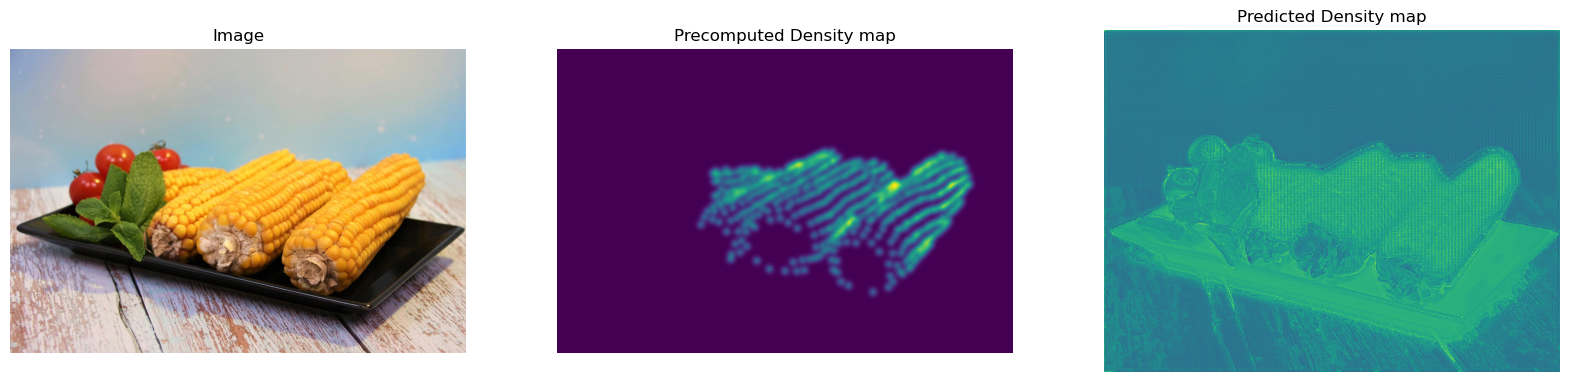

In [45]:
def plot_image_and_density(image_path, density_map_path, predicted_density_map):
    image = Image.open(image_path)
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    density_map = np.load(density_map_path)
    plt.imshow(density_map)
    plt.axis('off')
    plt.title("Precomputed Density map")

    plt.subplot(1, 3, 3)
    y_hat_np = predicted_density_map.squeeze().numpy()
    plt.imshow(y_hat_np)
    plt.axis('off')
    plt.title("Predicted Density map")
    plt.show()

# for image_name in test_images:
image_name = 'corn_290'
image_path = f"../datasets/corn_kernel_density/test/original_size_dmx100/sigma-12/{image_name}.jpg"
density_map_path = f"../datasets/corn_kernel_density/test/original_size_dmx100/sigma-12/{image_name}_class_0_density.npy"
predicted_density_map = predict_image(image_path)
# density_map = predict_image(image_path)
plot_image_and_density(image_path, density_map_path, predicted_density_map)

In [ ]:
# plot y_hat values in a histogram
plt.figure()
plt.hist(y_hat.flatten())
plt.show()


In [63]:
def count_annotated_instances(dir):
    """
    Count the number of annotated instances in each label file in the given directory.

    Args:
    - dir (str): The directory containing the label .txt files.

    Returns:
    - counts (dict): A dictionary containing the number of annotated instances for each image.
    """
    counts = {}
    for file in glob.glob(dir + "*.txt"):
        with open(file, "r") as in_file:
            lines = in_file.readlines()
        counts[Path(file).stem] = len(lines)
    return counts

In [64]:
def count_predictions(dir):
    """
    Count the number of predicted instances for each img the given directory.

    Args:
    - dir (str): The directory containing .jpg files.

    Returns:
    - counts (dict): A dictionary containing the number of predicted instances for each image.
    """
    counts = {}
    for file in glob.glob(dir + "*.jpg"):
        y_hat = predict_image(file)
        count = (torch.sum(y_hat).item())/100
        counts[Path(file).stem] = count
    return counts

In [ ]:
label_path = "../datasets/corn_kernel_yolo/labels/test/"
img_path = "../datasets/corn_kernel_yolo/images/test/"
true_dict = count_annotated_instances(label_path)
pred_dict = count_predictions(img_path)

In [70]:
true_dict_sorted = {k: v for k, v in sorted(true_dict.items(), key=lambda item: item[1])}
# # multiply pred dict by 100
# pred_dict = {k: v*100 for k, v in sorted(pred_dict.items(), key=lambda item: item[1])}

In [67]:
# Compute Count MAPE for each model
def count_mape(true_dict, pred_dict):
    """
    Compute the Count Mean Absolute Percentage Error (MAPE) between the true and predicted counts.

    Args:
    - true_dict (dict): A dictionary containing the true number of instances for each image.
    - pred_dict (dict): A dictionary containing the predicted number of instances for each image.

    Returns:
    - mape (float): The Count MAPE between the true and predicted counts.

    Note: The keys in `true_dict` and `pred_dict` are the image filenames and values are the counts.
    """
    mape = 0
    for key in true_dict.keys():
        mape += abs(true_dict.get(key) - pred_dict.get(key,0)) / true_dict.get(key)
    return mape / len(true_dict)

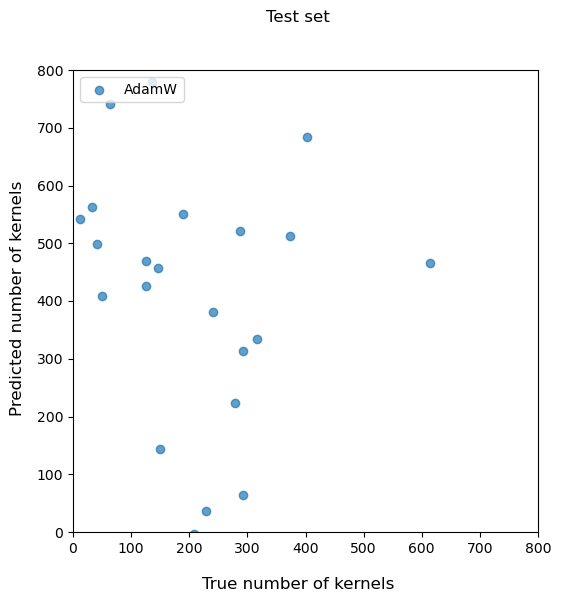

In [73]:
# Plot predicted vs true counts
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Test set")
fig.supxlabel("True number of kernels")
fig.supylabel("Predicted number of kernels")
gt_values = list(true_dict_sorted.values())
# Truncate axes to 800
ax.set_xlim(0, 800)
ax.set_ylim(0, 800)
# Adam
#ax.scatter(gt_values, [predicted_dict_adam.get(k,0) for k in test_dict_sorted.keys()], label="Adam", alpha=0.7, marker="^")
# AdamW
ax.scatter(gt_values, [pred_dict.get(k,0) for k in true_dict_sorted.keys()], label="AdamW", alpha=0.7, marker="o")
# SGD
#ax.scatter(gt_values, [predicted_dict_sgd.get(k,0) for k in test_dict_sorted.keys()], label="SGD", alpha=0.7, marker="s")
plt.legend(loc="upper left")